[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dominik-strutz/moon_oed/blob/main/00_c_inverse_problem.ipynb)

In [1]:
# MAKE SURE TO RUN THIS CELL FIRST
# this might take a minute or two
# This cell will install the necessary dependencies and import the necessary modules for the notebook to run in Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
    
if IN_COLAB:
    dependencies_installed = False

    if not dependencies_installed:
        ! rm -rf *
        ! git clone --quiet https://github.com/dominik-strutz/moon_oed tmp
        ! mv tmp/* .
        ! rm -rf tmp
        # only install the first 8 lines of the requirements file to only install the necessary dependencies
        ! head -3 requirements.txt > tmp.txt
        ! mv tmp.txt requirements.txt 
        ! pip install -q -r requirements.txt
        dependencies_installed = True
    from google.colab import output
    output.enable_custom_widget_manager()

In [2]:
import os
import torch
import emcee
import pandas as pd

from zuko.distributions import Joint, Truncated
from torch.distributions import Uniform, Normal, Independent

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('https://raw.githubusercontent.com/dominik-strutz/dotfiles/main/mystyle.mplstyle')

In [ ]:
kernel_df = pd.read_csv('data/sensitivity_kernels/sensitivity_kernels.csv')
freqs = kernel_df.keys()

velocity_model = pd.read_csv('data/velocity_model_no_ice.csv')
depths = torch.tensor(velocity_model['depth'].values)
vp_model = torch.tensor(velocity_model['vp'].values)
vs_model = torch.tensor(velocity_model['vs'].values)

velocity_model_ice = pd.read_csv('data/velocity_model_ice.csv')
vp_model_ice = torch.tensor(velocity_model_ice['vp'].values)
vs_model_ice = torch.tensor(velocity_model_ice['vs'].values)

# for now just take the mean velocity in the shallowest 5 layers
vp_homogeneous = vp_model[:5].mean().item()
vp_ice_homogeneous = vp_model_ice[:5].mean().item()

print('vp_homogeneous:', vp_homogeneous)
print('vp_ice_homogeneous:', vp_ice_homogeneous)

vp_homogeneous: 108.0
vp_ice_homogeneous: 332.0


# Set up Toy-Problem

## Setup Design

In [4]:
length_x = 500
length_y = 500 

N_rec = 10
# generate 10 random receiver positions
# draw from sobol sequence to have near equidistant points
# which should be good as a first guess of a good receiver layout
from torch.quasirandom import SobolEngine
sobol = SobolEngine(dimension=2, scramble=True, seed=19)

design = sobol.draw(N_rec)
design[:, 0] *= length_x
design[:, 1] *= length_y

## Setup Ice Body

In [5]:
ice_bodies_mean = torch.tensor(
    [[300, 230]])
ice_bodies_std = torch.tensor(
    [[40, 60]])
ice_bodies_amp = torch.tensor(
    [vp_ice_homogeneous+10])
ice_bodies_theta = torch.tensor(
    [0.3*torch.pi])

## Plot setup

In [6]:
from helpers.plotting import gaussian_2d

x = torch.linspace(0, length_x, 100)
y = torch.linspace(0, length_y, 100)
X, Y = torch.meshgrid(x, y, indexing='ij')
X = X.flatten()
Y = Y.flatten()

prior_velocity = gaussian_2d(
    X.unsqueeze(-1), Y.unsqueeze(-1),
    ice_bodies_mean,
    ice_bodies_std,
    ice_bodies_amp,
    ice_bodies_theta
    ).reshape(len(x), len(y), 1).mean(dim=-1)

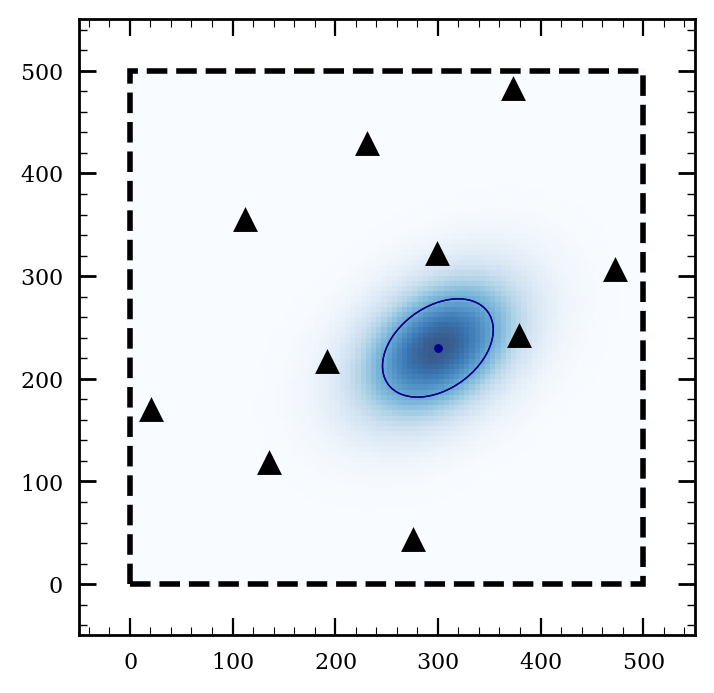

In [7]:
from helpers.plotting import plot_ellipses
# Plot the setup
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200)

ax.pcolormesh(x, y, prior_velocity.T, cmap='Blues', shading='auto', zorder=-2, alpha=0.8)

plot_ellipses(ax, ice_bodies_mean, ice_bodies_std, ice_bodies_theta, ice_bodies_amp,
              scatter_kwargs={'c': 'darkblue', 's': 10},
              ellipse_kwargs={'edgecolor': 'darkblue', 'linewidth': 0.5})
              

ax.scatter(design[:, 0], design[:, 1],
           linewidths=0,
           marker='^', color='k', s=80)

buffer=50

ax.set_xlim(0-buffer, length_x+buffer)
ax.set_ylim(0-buffer, length_y+buffer)
# draw rectangle
ax.add_patch(plt.Rectangle(
    (0, 0), length_x, length_y,
    fill=None, linestyle='dashed', color='black', linewidth=2))

ax.set_aspect('equal')


plt.show()

# Define Forward Model

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
from helpers.forward import ForwardModelHomogeneous
            
true_model = torch.hstack([
    ice_bodies_mean, ice_bodies_std,
    ice_bodies_amp.unsqueeze(-1),
    ice_bodies_theta.unsqueeze(-1)])

fwd_model = ForwardModelHomogeneous(vp_homogeneous)
phase_arrivals = fwd_model(true_model, design).squeeze()

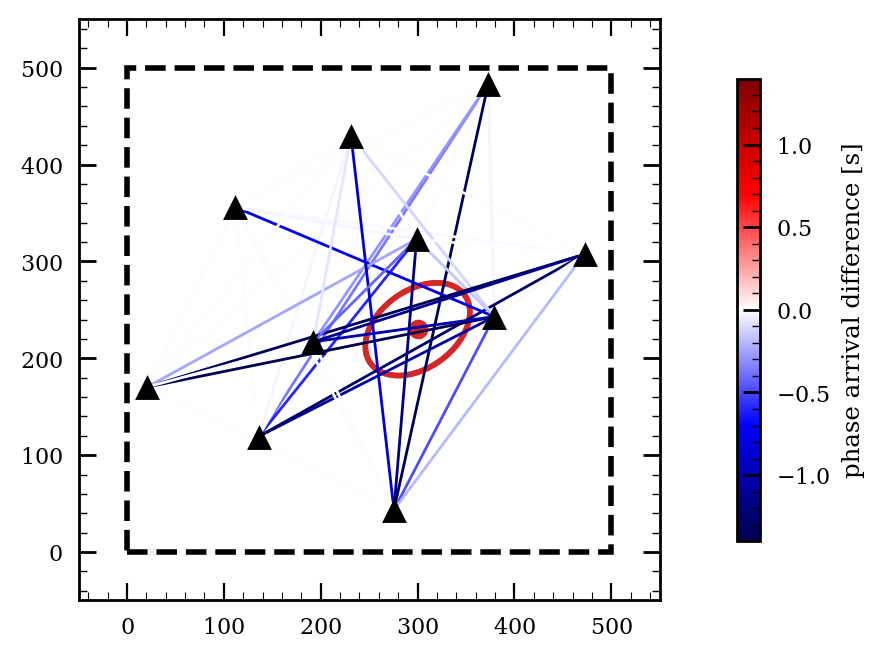

In [10]:
combinations = torch.combinations(
    torch.tensor(range(len(design))),
    2, with_replacement=False)

start_points = design[combinations[:, 0]]
end_points = design[combinations[:, 1]]
distances = torch.norm(start_points - end_points, dim=1)

homogeneous_phase_arrivals = distances / vp_homogeneous
abs_diff = (phase_arrivals - homogeneous_phase_arrivals) #/ homogeneous_phase_arrivals


# Plot the setup
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)

plot_ellipses(
    ax, ice_bodies_mean, ice_bodies_std, ice_bodies_theta, ice_bodies_amp,
    scatter_kwargs={'c': 'tab:red'},
    ellipse_kwargs={'edgecolor': 'tab:red'})

ax.scatter(design[:, 0], design[:, 1],
           linewidths=0,
           marker='^', color='k', s=80,
           zorder=4)

buffer=50

ax.set_xlim(0-buffer, length_x+buffer)
ax.set_ylim(0-buffer, length_y+buffer)
# draw rectangle
ax.add_patch(plt.Rectangle(
    (0, 0), length_x, length_y,
    fill=None, linestyle='dashed', color='black', linewidth=2))

ax.set_aspect('equal')
max_error = abs_diff.abs().max()

# Plot the connections between receivers with color according to the relative error
for (start, end, error) in zip(start_points, end_points, abs_diff):
    
    # color = plt.cm.managua((error.item() + max_error.item()) / (2 * max_error.item()))
    color = plt.get_cmap('seismic')((error.item() + max_error.item()) / (2 * max_error.item()))
    
    ax.plot([start[0], end[0]], [start[1], end[1]],
            color=color, lw=1.0,
            # lw=0.5 + 1.0 * (abs(error.item()) / max_error.item()),
            zorder=3)

cbar = plt.cm.ScalarMappable(cmap='seismic')
cbar.set_array(abs_diff)
cbar.set_clim(-max_error, max_error)

cbar = plt.colorbar(cbar, ax=ax, shrink=0.6, pad=0.100)
cbar.set_label('phase arrival difference [s]')

plt.show()

# Data Likelihood

In [11]:
from helpers.forward import DataLikelihoodHomogeneous
    
data_noise = 0.2
data_likelihood = DataLikelihoodHomogeneous(fwd_model, data_noise)

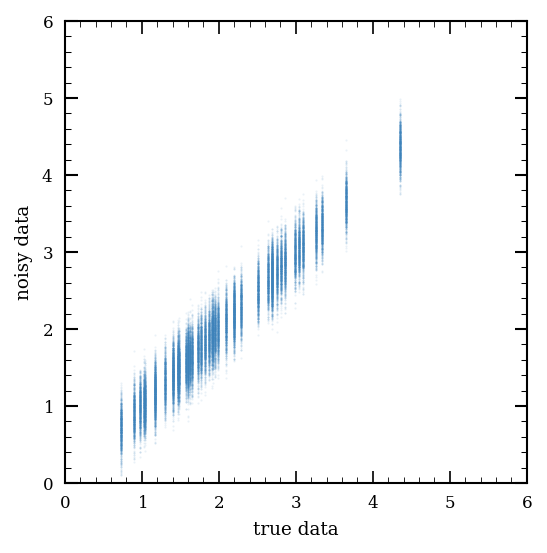

In [12]:
data = fwd_model(true_model, design)
data_noisy = data_likelihood(true_model, design).sample([int(1e3)])

fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

ax.scatter(
    data.unsqueeze(-1).repeat(1000, 1).numpy(),
    data_noisy.numpy(), s=1, alpha=0.1, linewidths=0)

ax.set_xlim(0, 6)
ax.set_ylim(0, 6)

ax.set_aspect('equal')
ax.set_xlabel('true data')
ax.set_ylabel('noisy data')

plt.show()

# Inverse Problem

In [13]:
coordinate_prior = Independent(
    Truncated(
        Normal(torch.tensor([250.0, 250.0]), 200.0),
        lower=0.0, upper=length_x), 1)
std_prior = Independent(
    Truncated(
        Normal(torch.tensor([50.0, 50.0]), 30.0),
        lower=10.0, upper=100.0), 1)
amp_prior = Independent(Normal(torch.tensor([350.0]), 10.0),1)
theta_prior = Independent(Uniform(torch.tensor([0.0]), torch.tensor([0.5 * torch.pi])), 1)

parameter_names = [r'$x$', r'$y$', r'$\sigma_x$', r'$\sigma_y$', r'$A$', r'$\theta$']
prior_dist = Joint(coordinate_prior, std_prior, amp_prior, theta_prior)

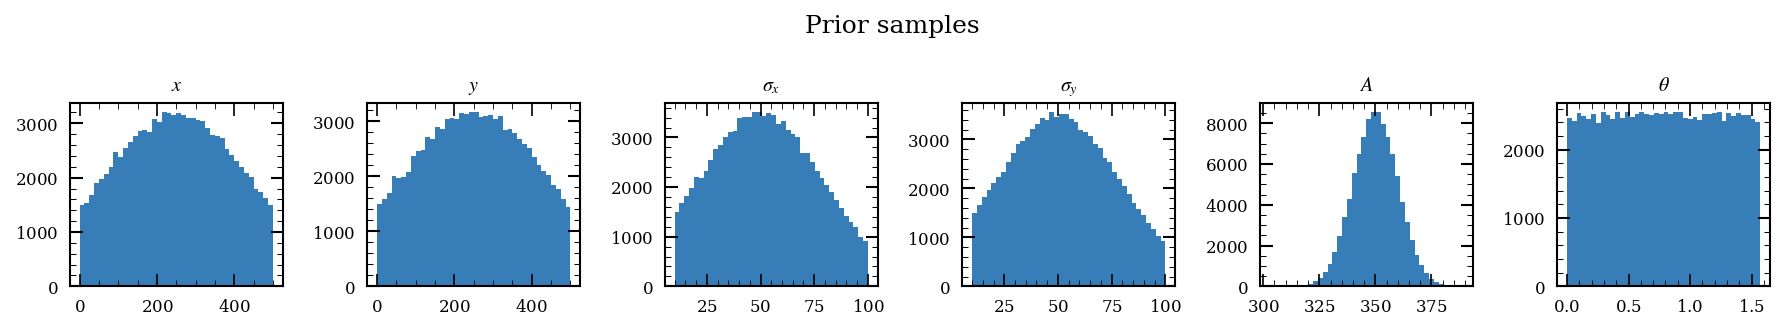

In [14]:
prior_samples = prior_dist.sample((int(1e5),))
fig, ax = plt.subplots(1, prior_dist.event_shape[0], figsize=(2*prior_dist.event_shape[0], 2.2))

for i, ax_i in enumerate(ax):
    ax_i.hist(prior_samples[..., i].flatten(), bins=40)
    ax_i.set_title(parameter_names[i])

fig.suptitle('Prior samples')

plt.tight_layout()
plt.show()

In [15]:
def log_prob_fn(parameters):
    parameters = torch.tensor(parameters)
    return prior_dist.log_prob(parameters.unsqueeze(0)).squeeze() + data_likelihood(parameters, design).log_prob(data)

nwalkers = 32
nsteps = 50000
ndim = prior_dist.event_shape[0]

initial_positions = prior_dist.sample((nwalkers,))

filename = f'data/posterior_samples_{nwalkers}walkers_{nsteps}steps.h5'

if not os.path.exists(filename):
    backend = emcee.backends.HDFBackend(filename)
    initial_positions = prior_dist.sample((nwalkers,))

    # Create the sampler
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_prob_fn, backend=backend)

    # Run the MCMC
    print("Running MCMC...")
    sampler.run_mcmc(initial_positions, nsteps, progress='notebook')
else:
    sampler = emcee.backends.HDFBackend(filename)

Running MCMC...


  0%|          | 0/50000 [00:00<?, ?it/s]

In [16]:
samples = torch.tensor(sampler.get_chain(discard=nsteps//5, thin=nsteps//1000, flat=True))

fig, ax = plt.subplots(1, prior_dist.event_shape[0], figsize=(2*prior_dist.event_shape[0], 2.2))

param_limits = [
    [ice_bodies_mean[0, 0].item()-50, ice_bodies_mean[0, 0].item()+50],
    [ice_bodies_mean[0, 1].item()-50, ice_bodies_mean[0, 1].item()+50],
    [10, 100],
    [10, 100],
    [ice_bodies_amp.item()-30, ice_bodies_amp.item()+30],
    [0, 0.5*torch.pi]
]

for i, ax_i in enumerate(ax):
    ax_i.hist(
        prior_samples[..., i].flatten(), bins=50, alpha=0.5,
        color='gray', density=True, range=param_limits[i])
    ax_i.hist(
        samples[:, i], bins=50, color='tab:red',
        density=True, range=param_limits[i])
    ax_i.set_title(parameter_names[i])
    
    ax_i.axvline(true_model[0, i].item(), color='k')
    
fig.suptitle('Posterior samples')
plt.tight_layout()
plt.show()

AttributeError: You must run the sampler with 'store == True' before accessing the results

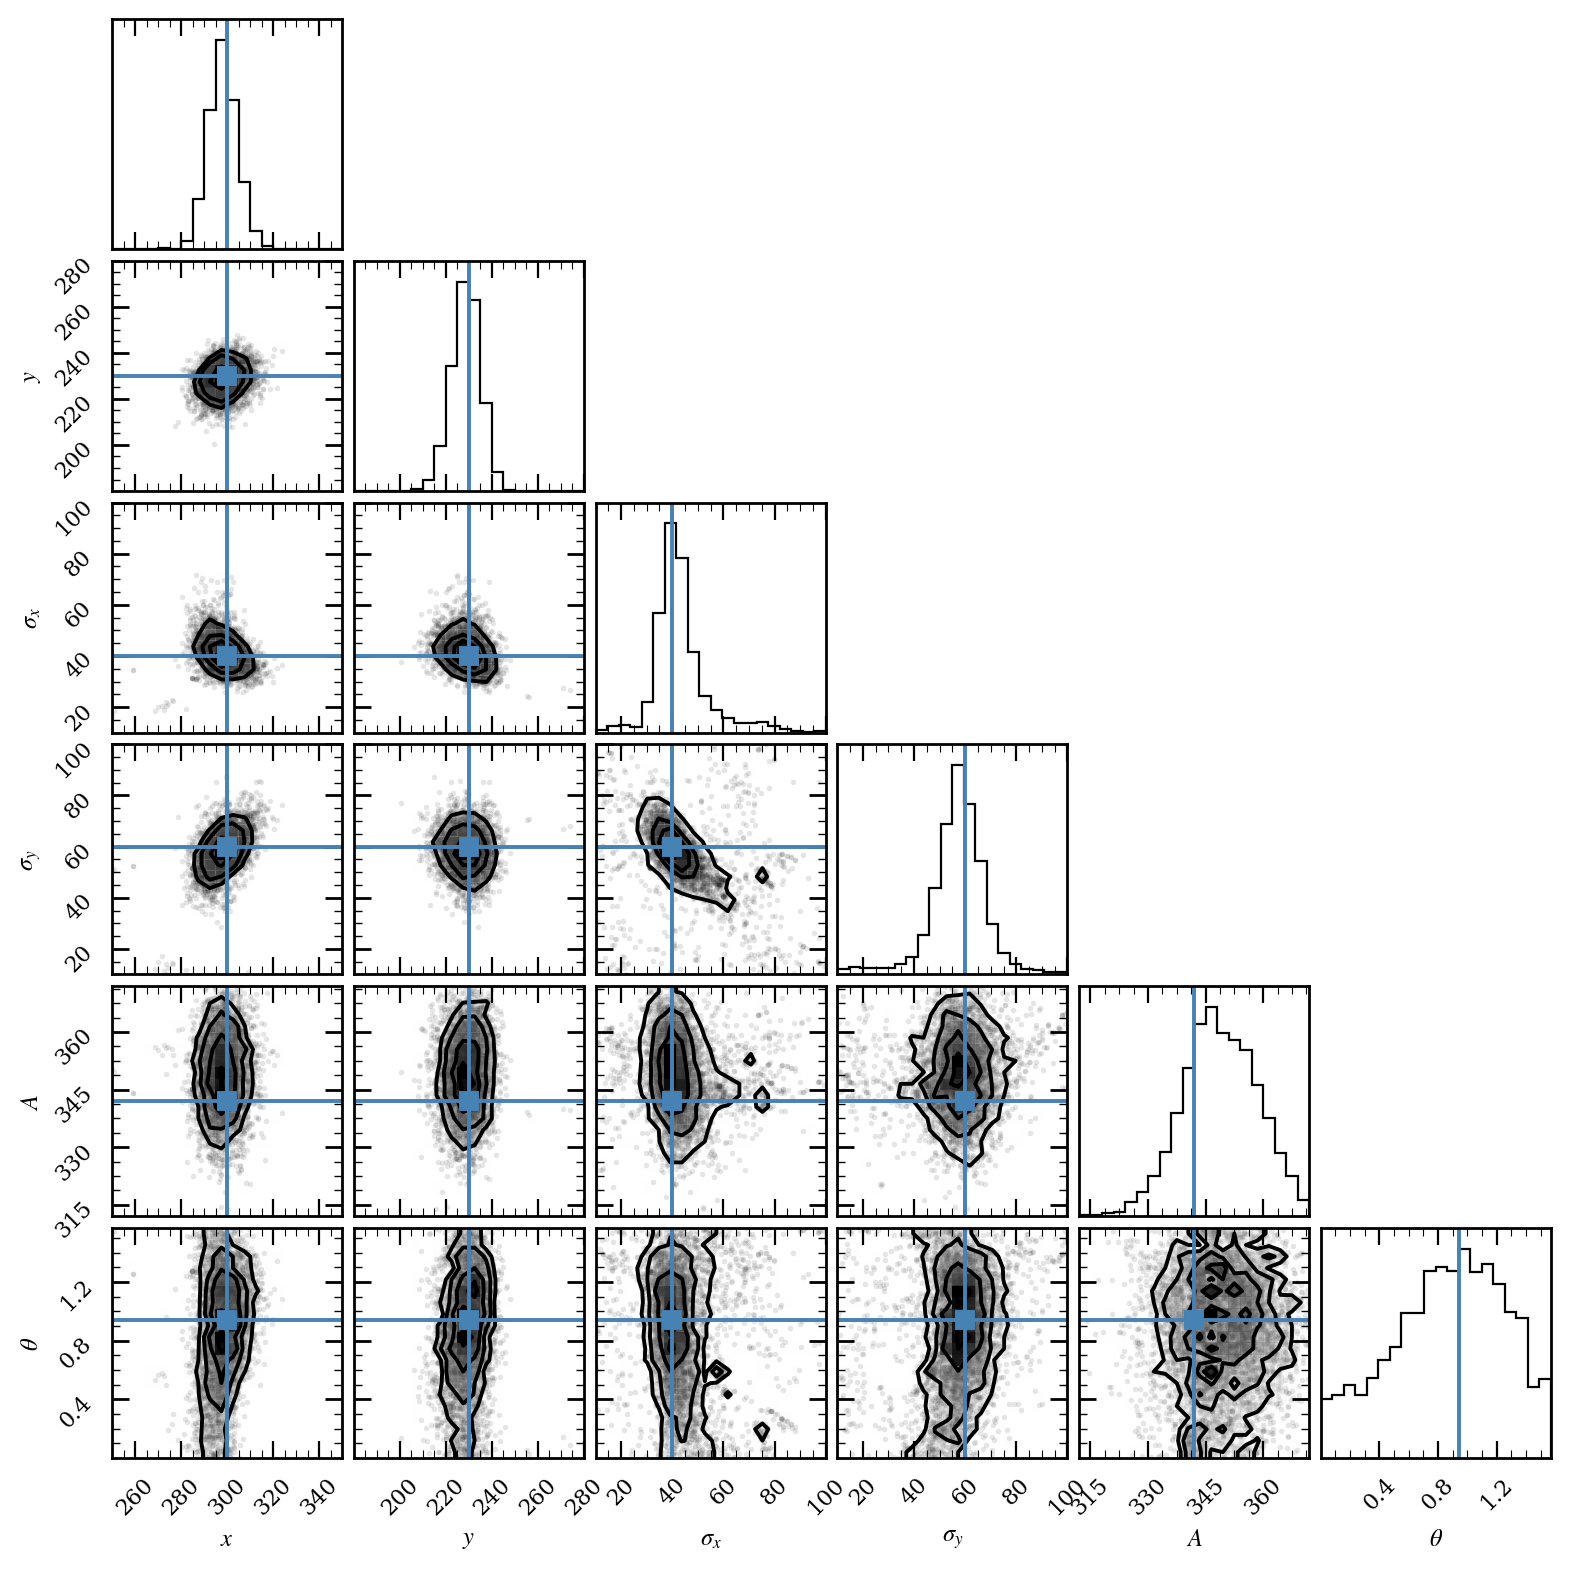

In [17]:
import corner

fig = plt.figure(figsize=(8, 8), dpi=200)

corner.corner(
    samples.numpy(),
    fig=fig, labels=parameter_names,
    truths=true_model[0].numpy(), range=param_limits)

plt.show()

In [18]:
few_samples = torch.tensor(sampler.get_chain(discard=nsteps//5, thin=nsteps//10, flat=True))

post_means = few_samples[..., :2]
post_stds = few_samples[..., 2:4]
post_amps = few_samples[..., 4]
post_thetas = few_samples[..., 5]

average_posterior = gaussian_2d(
    X.unsqueeze(-1), Y.unsqueeze(-1),
    post_means,
    post_stds,
    post_amps,
    post_thetas).reshape(len(x), len(y), len(few_samples)).mean(dim=-1)

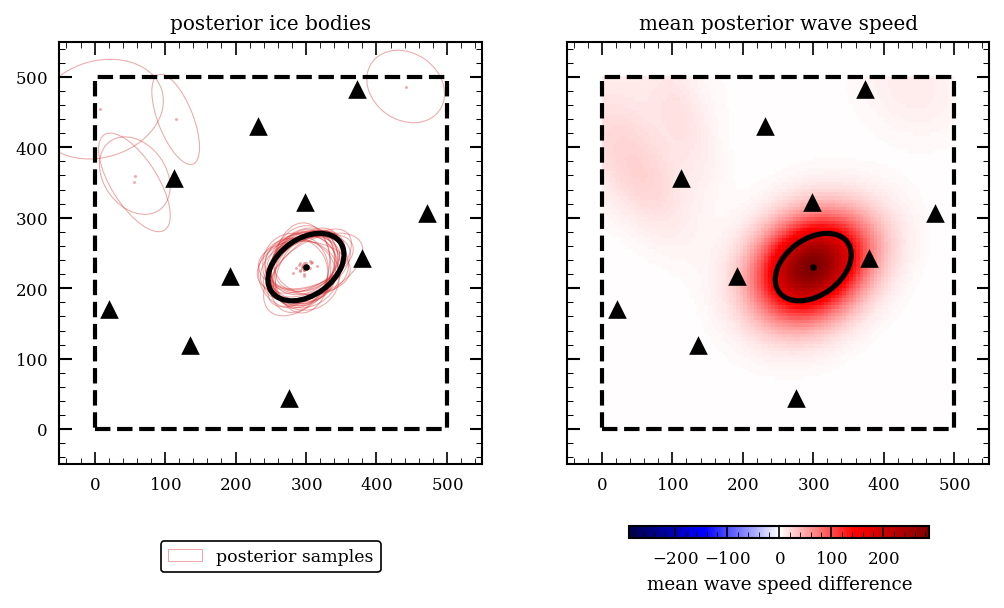

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), dpi=150, sharex=True, sharey=True)

plot_ellipses(
    ax1, post_means, post_stds, post_thetas, post_amps,
    scatter_kwargs={'c': 'tab:red', 's':2, 'alpha':0.4},
    ellipse_kwargs={'edgecolor': 'tab:red', 'linewidth': 0.5, 'label': 'posterior samples', 'alpha':0.4},
    n_max=100)

# remove duplicate legend entries
handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# legend below plot
ax1.legend(by_label.values(), by_label.keys(),
              loc='upper center', bbox_to_anchor=(0.5, -0.1),
              ncol=2, fontsize='small')

ax1.set_title('posterior ice bodies')
 
im = ax2.imshow(
    average_posterior.T, extent=(0, length_x, 0, length_y),
    origin='lower', cmap='seismic', zorder=-1, clim=(-abs(average_posterior).max(), abs(average_posterior).max()))
ax2.set_title('mean posterior wave speed')

# add axes below ax2 for colorbar
cbarax = fig.add_axes([0.6, 0.02, 0.25, 0.02])

cbar = fig.colorbar(im, cax=cbarax, orientation='horizontal', shrink=0.6, label='mean wave speed difference')

for ax in (ax1, ax2):
    
    plot_ellipses(
        ax, ice_bodies_mean, ice_bodies_std, ice_bodies_theta, ice_bodies_amp,
        scatter_kwargs={'c': 'k', 's':10},
        ellipse_kwargs={'edgecolor': 'k', 'linewidth': 2.5, 'label': 'true ice body'})
    buffer=50

    ax.set_xlim(0-buffer, length_x+buffer)
    ax.set_ylim(0-buffer, length_y+buffer)

    # draw rectangle
    ax.add_patch(plt.Rectangle(
        (0, 0), length_x, length_y,
        fill=None, linestyle='dashed', color='black', linewidth=2))
    ax.set_aspect('equal')
        
    ax.scatter(design[:, 0], design[:, 1],
                linewidths=0,
                marker='^', color='k', s=80)

plt.show()